# Natural Language Processing with Tensorflow

This notebook contains:
  * Downloading a text dataset
  * Visualizing the data
  * Converting text into numbers using tokenization
  * Turning tokenized text into an embedding
  * Modelling a text data
    * Starting with a baseline (TF-IDF)
    * Building several deep learning text models
      * Dense, LSTM, GRU, Conv1D, Transfer Learning
  * Comparing the performance of each of our models
  * Combining our models into an ensemble
  * Saving and loading a trained model
  * Finding the most wrong predictions

## Checking the GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b202e245-1d77-8029-bfd4-e31b5f6b205f)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-12 09:32:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-12 09:32:04 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Download a text dataset

In [4]:
# Download data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2023-02-12 09:32:07--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-02-12 09:32:07 (146 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
# Unzip data
unzip_data("nlp_getting_started.zip")

# Visualizing the dataset

In [6]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many samples total
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df)+len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [11]:
# Visualizing some random samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: {text}")
  print("---")

Target: 1 (real disaster)
Text: DC Media: tip for getting updates on the derailed #WMATA train today - ask them about movie night and quickly change the subject!
---
Target: 0 (not real disaster)
Text: A Laois girl advertised for a new friend to replace her loved-up BFF and has been inundated http://t.co/IGM2fc4T0M http://t.co/YiLTu7SXAr
---
Target: 1 (real disaster)
Text: wild night in the village of pugwash every fire truck is out that the town has which is like a fire truck for every house -population:6
---
Target: 1 (real disaster)
Text: SIGALERT UPDATE #3***N-133 CLOSED AT 5 FWY UFN***- TRASH TRUCK FIRE
---
Target: 1 (real disaster)
Text: I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-
---


### Split the data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df_shuffled['text'].to_numpy(), train_df_shuffled['target'].to_numpy(), test_size=0.1, random_state=42)

In [13]:
# Check the sizes of train and val sets
len(X_train), len(X_val), len(y_train), len(y_val)

(6851, 762, 6851, 762)

# Converting Text into Numbers

### Text Vectorization

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

In [15]:
# Find average number of tokens in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

15

In [16]:
#@title Default title text
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode="int",
                                   output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nVectorized text: \n{text_vectorizer(random_sentence)}")

Original text:
Lee does comedy: ÛÏ@LeeJasper: Working class Tories prepare for your Armageddon. #InterestRateRiseÛ
Vectorized text: 
[   1  350 3986 6448 1049  784 7469 1184   10   33  443    1    0    0
    0]


In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length="max_length",
                             name="embedding_1")

embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\nEmbedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
RT @kotowsa: South SudanÛªs war on women: survivors say rape has become 'just a normal thing' 
https://t.co/MexwoHd3TG http://t.co/gB46FiD2wE
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04964176, -0.02949712,  0.0338049 , ..., -0.04459883,
          0.03570438,  0.03405895],
        [ 0.02929107, -0.04759613,  0.01970411, ...,  0.04896659,
         -0.00324267,  0.03595355],
        [ 0.01428637, -0.01482628,  0.04899493, ...,  0.04638069,
         -0.00310361, -0.0338231 ],
        ...,
        [ 0.04530488, -0.03334178, -0.04476644, ...,  0.04322299,
          0.0158285 , -0.00154085],
        [-0.04493821, -0.03544257,  0.00661273, ..., -0.01402891,
          0.01610526, -0.0120369 ],
        [ 0.04389444,  0.01508658,  0.0116619 , ..., -0.0079661 ,
         -0.01641283, -0.0460391 ]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 4.9641762e-02, -2.9497122e-02,  3.3804905e-02, -7.6551922e-03,
       -2.9702533e-02,  3.7786160e-02,  4.7861662e-02, -2.1769440e-02,
       -4.0427931e-03,  8.5689127e-05, -4.3082513e-02, -1.1703420e-02,
       -4.8105087e-02, -3.1945251e-02, -4.9424436e-02, -1.2912862e-03,
        3.4830224e-02, -4.4907689e-02, -8.6952336e-03,  8.7875836e-03,
        3.6908899e-02,  2.0613123e-02,  2.6575778e-02,  3.1764392e-02,
       -4.4780590e-02, -2.3452593e-02, -2.5958015e-02,  2.3089562e-02,
       -2.0203043e-02,  2.0236779e-02,  1.3818145e-03, -3.9435197e-02,
       -4.9747705e-02, -3.5646185e-03, -7.5720660e-03,  4.8057448e-02,
        2.4625991e-02,  6.0192347e-03,  2.6185039e-02, -6.1535947e-03,
       -5.4016486e-03, -4.9779475e-02,  4.9940754e-02, -5.7302788e-04,
        8.6557120e-05,  1.6268108e-02, -4.2871177e-02,  4.5388091e-02,
        4.1389193e-02, -3.3400372e-02,  2.2966180e-02, -1.0001231e-02,
        3.2407489e-02,  2.020

# Modelling a text dataset

* **Model 0**: Naive bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: Tensorflow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(X_val, y_val)
print(f"Our baseline model achieves the accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves the accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(X_val)
baseline_preds[:20]


array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments
  * Accuracy
  * Precision
  * Recall
  * F1-Score

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=y_val, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A Simple dense model

In [29]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [30]:
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [31]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
# Get summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Fit the model
model_1.history = model_1.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=[X_val, y_val],
                              callbacks=[create_tensorboard_callback(dir_name="SAVE_DIR",
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: SAVE_DIR/simple_dense_model/20230212-093212
Epoch 1/5
215/215 [==============================] - 15s 48ms/step - loss: 0.6091 - accuracy: 0.6987 - val_loss: 0.5357 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4413 - accuracy: 0.8199 - val_loss: 0.4689 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3465 - accuracy: 0.8615 - val_loss: 0.4586 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2849 - accuracy: 0.8918 - val_loss: 0.4636 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2380 - accuracy: 0.9120 - val_loss: 0.4760 - val_accuracy: 0.7861


In [34]:
# Check the results
model_1.evaluate(X_val, y_val)

24/24 [==============================] - 0s 3ms/step - loss: 0.4760 - accuracy: 0.7861


[0.4759516417980194, 0.7860892415046692]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.00858546,  0.05715428,  0.01920526, ...,  0.01730293,
          0.0535606 , -0.02629203],
        [ 0.03614122, -0.04334312,  0.01433716, ...,  0.04420601,
          0.00264744,  0.05506763],
        [-0.04686018, -0.03068918,  0.00509531, ...,  0.01371051,
          0.01748122, -0.05614194],
        ...,
        [-0.0017317 ,  0.00859125,  0.0098521 , ..., -0.02892448,
          0.0062727 , -0.03033763],
        [-0.03457546,  0.05467743, -0.00863202, ..., -0.07389043,
          0.04091162, -0.09307878],
        [-0.03965897,  0.11102781, -0.03288678, ..., -0.0950343 ,
          0.10737838, -0.03020179]], dtype=float32)>]

In [36]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [37]:
# Make predictions
model_1_pred_probs = model_1.predict(X_val)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.40439725],
       [0.74622995],
       [0.9976078 ],
       [0.11232527],
       [0.10861765],
       [0.9368843 ],
       [0.916706  ],
       [0.9927003 ],
       [0.97117424],
       [0.2607337 ]], dtype=float32)

In [38]:
# Turn prediction probabilities into single dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true = y_val, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

### Model 2: LSTM

In [40]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
# x = layers.Dense(1, activation="sigmoid")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)


In [41]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [42]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [43]:
# Fit the model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230212-093255
Epoch 1/5
215/215 [==============================] - 12s 38ms/step - loss: 0.5109 - accuracy: 0.7435 - val_loss: 0.4552 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3166 - accuracy: 0.8701 - val_loss: 0.5125 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2177 - accuracy: 0.9161 - val_loss: 0.5977 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1507 - accuracy: 0.9461 - val_loss: 0.6749 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1066 - accuracy: 0.9604 - val_loss: 0.8130 - val_accuracy: 0.7546


In [44]:
# Make prediction on the validation dataset
model_2_pred_probs = model_2.predict(X_val)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.01545177],
        [0.77683383],
        [0.9987908 ],
        [0.08475956],
        [0.00272157],
        [0.99901927],
        [0.96395284],
        [0.9995177 ],
        [0.99937147],
        [0.2608856 ]], dtype=float32))

In [45]:
# Round up predictions and reduce it to 1D array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [46]:
# Calculate LSTM model results
model_2_results = calculate_results(y_val, model_2_preds)
model_2_results

{'accuracy': 75.45931758530183,
 'precision': 0.7552799761217521,
 'recall': 0.7545931758530183,
 'f1': 0.7527017331356143}

### Model 3: GRU

In [47]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="GRU")

In [48]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
model_3.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________________

In [50]:
# Fit the model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230212-093319
Epoch 1/5
215/215 [==============================] - 11s 38ms/step - loss: 0.5236 - accuracy: 0.7324 - val_loss: 0.4571 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3192 - accuracy: 0.8692 - val_loss: 0.4931 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2178 - accuracy: 0.9174 - val_loss: 0.5578 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1552 - accuracy: 0.9463 - val_loss: 0.6135 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1171 - accuracy: 0.9604 - val_loss: 0.6087 - val_accuracy: 0.7703


In [51]:
# Make prediction on validation data
model_3_pred_probs = model_3.predict(X_val)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.31384972],
       [0.916856  ],
       [0.9966509 ],
       [0.11640149],
       [0.016138  ],
       [0.9920596 ],
       [0.752099  ],
       [0.99629635],
       [0.9970048 ],
       [0.48945272]], dtype=float32)

In [52]:
# Round up the prediction and convert it to 1D array
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate result
model_3_results = calculate_results(y_val, model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701965974536404,
 'recall': 0.7703412073490814,
 'f1': 0.7694283709964855}

### Model 4: Bidirectional RNN Model

In [54]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in tensorflow
input = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(input)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(input, output, name="model_4_Bidirectional")

In [55]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [56]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [57]:
# Fit the model
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230212-093339
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.5088 - accuracy: 0.7435 - val_loss: 0.4586 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3141 - accuracy: 0.8720 - val_loss: 0.5140 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.2133 - accuracy: 0.9171 - val_loss: 0.5615 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1460 - accuracy: 0.9512 - val_loss: 0.6609 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1029 - accuracy: 0.9650 - val_loss: 0.7074 - val_accuracy: 0.7664


In [58]:
# Make predictions with bidirectional RNN on validation data
model_4_pred_probs = model_4.predict(X_val)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.03569461],
       [0.8727136 ],
       [0.9996032 ],
       [0.15495588],
       [0.0031748 ],
       [0.9982749 ],
       [0.96850395],
       [0.9997379 ],
       [0.99968994],
       [0.3748454 ]], dtype=float32)

In [59]:
# Convert prediction probabilities to labels
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate bidirection model results
model_4_results = calculate_results(y_val, model_4_pred)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7660179630810368,
 'recall': 0.7664041994750657,
 'f1': 0.7658701917905647}

### Model 5: Conv1D (Convolutional Neural Network for Text)

In [61]:
# Test out the embedding, 1D Convolutional and max pooling
embedding_test = embedding(text_vectorizer(['This is a test sentence']))
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [62]:
embedding_test[:1], max_pool_output[:1], conv_1d_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.04666731, -0.03191847, -0.04702565, ..., -0.04014509,
           0.03295258, -0.04626161],
         [-0.12015039,  0.04152115, -0.04456668, ..., -0.06319403,
           0.03554367, -0.11704902],
         [-0.04624516, -0.02642966, -0.00197948, ..., -0.02241999,
           0.02588728, -0.00635432],
         ...,
         [-0.00858546,  0.05715428,  0.01920526, ...,  0.01730293,
           0.0535606 , -0.02629203],
         [-0.00858546,  0.05715428,  0.01920526, ...,  0.01730293,
           0.0535606 , -0.02629203],
         [-0.00858546,  0.05715428,  0.01920526, ...,  0.01730293,
           0.0535606 , -0.02629203]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 32), dtype=float32, numpy=
 array([[0.03118849, 0.01246882, 0.02020044, 0.02229259, 0.03730856,
         0.05412821, 0.04694697, 0.02287071, 0.06993236, 0.        ,
         0.01744868, 0.1480147 , 0.08162764, 0.        , 0.07480489,
         0.13929686, 0.13766113

In [63]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [64]:
# model_5 summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1920      
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [65]:
# Compile model_5
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Fit the model
model_5_history = model_5.fit(X_train, y_train, epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230212-093407
Epoch 1/5
215/215 [==============================] - 13s 48ms/step - loss: 0.6434 - accuracy: 0.6199 - val_loss: 0.6214 - val_accuracy: 0.6496
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.6130 - accuracy: 0.6554 - val_loss: 0.6092 - val_accuracy: 0.6535
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.6025 - accuracy: 0.6673 - val_loss: 0.6095 - val_accuracy: 0.6640
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.5960 - accuracy: 0.6707 - val_loss: 0.6104 - val_accuracy: 0.6640
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.5882 - accuracy: 0.6755 - val_loss: 0.6152 - val_accuracy: 0.6575


In [67]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(X_val)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.38780528],
       [0.644356  ],
       [0.79403955],
       [0.18324095],
       [0.26747268],
       [0.813706  ],
       [0.7399439 ],
       [0.43128905],
       [0.5537848 ],
       [0.38806295]], dtype=float32)

In [68]:
# Convert predictions to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 0., 1., 0.], dtype=float32)>

In [69]:
# Calculate model_5 results
model_5_results = calculate_results(y_val, model_5_preds)
model_5_results

{'accuracy': 65.74803149606299,
 'precision': 0.6751809869920106,
 'recall': 0.65748031496063,
 'f1': 0.635935029891247}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [70]:
# Example pof pre trained embedding with universal sentence encoder
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])


tf.Tensor(
[ 0.03596691 -0.08579469 -0.01152741  0.00525983 -0.01852173 -0.05042012
 -0.03616941  0.00534678  0.04805915  0.04690745 -0.03723331 -0.01149543
  0.04352415  0.0705099   0.07093762 -0.08180429  0.00871717 -0.04654121
 -0.02245775  0.04686872  0.00202255  0.03099073  0.02043565  0.06392168
 -0.07641087  0.08421177 -0.04576039 -0.00106165 -0.02059421  0.01241105
  0.05727538  0.03815622 -0.02742113 -0.00354347 -0.09832585 -0.01244855
  0.03865629  0.05031955 -0.02362504  0.00321848  0.03225213  0.00738092
  0.04473101 -0.00412239  0.01151604  0.02837726  0.00060137 -0.05903351
 -0.00494343 -0.00688529], shape=(50,), dtype=float32)


In [71]:
embed_samples[0].shape

TensorShape([512])

In [72]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         input_shape=[],
                                         dtype="string",
                                         trainable=False,
                                         name="USE")


In [73]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
    sentence_encoding_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["Accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
# Fit the model
model_6_history = model_6.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_val, y_val),
                              callbacks=create_tensorboard_callback(SAVE_DIR,"tf_hub_sentence_encoder"))

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230212-093524
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5014 - Accuracy: 0.7848 - val_loss: 0.4474 - val_Accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4138 - Accuracy: 0.8142 - val_loss: 0.4354 - val_Accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3990 - Accuracy: 0.8222 - val_loss: 0.4313 - val_Accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3918 - Accuracy: 0.8273 - val_loss: 0.4275 - val_Accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3856 - Accuracy: 0.8298 - val_loss: 0.4300 - val_Accuracy: 0.8110


In [75]:
# Make predictions
model_6_pred_probs = model_6.predict(X_val)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.14727871],
       [0.73364234],
       [0.99025774],
       [0.20537557],
       [0.7162445 ],
       [0.6636177 ],
       [0.98131907],
       [0.9767761 ],
       [0.9223794 ],
       [0.09318529]], dtype=float32)

In [76]:
# Convert probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [77]:
# Calculate model_6 results
model_6_results = calculate_results(y_val, model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

### Comparing the performance of each of our models

In [78]:
# combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1D": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.459318,0.755280,0.754593,0.752702
gru,77.034121,0.770197,0.770341,0.769428
bidirectional,76.640420,0.766018,0.766404,0.765870
conv1D,65.748031,0.675181,0.657480,0.635935
tf_hub_sentence_encoder,81.102362,0.814034,0.811024,0.809202


In [79]:
# Reduce the accuracy to same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

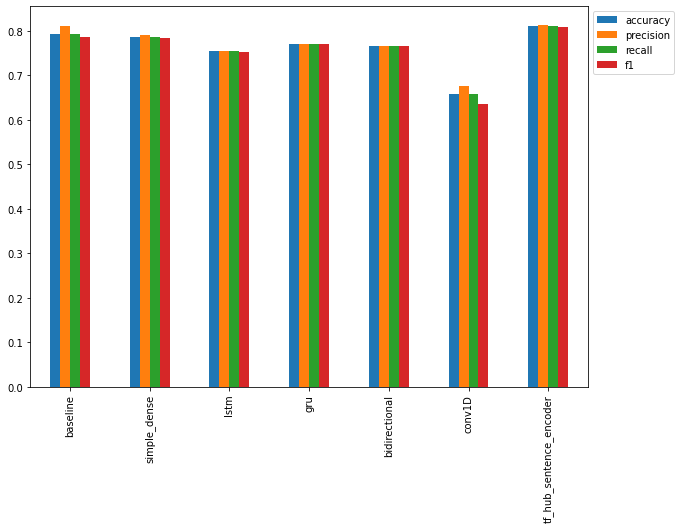

In [80]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

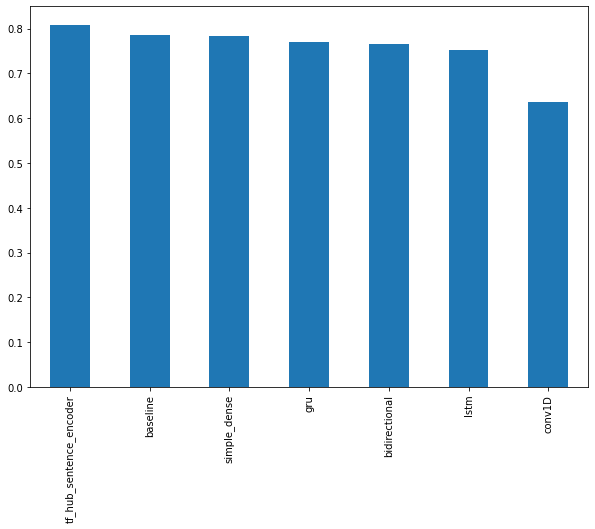

In [81]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))